# 데이터

In [1]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
from itertools import combinations
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

from keras.utils.vis_utils import plot_model

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="/aiffel/aiffel/dlthon-minions/share/data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
2215,2215,기타 괴롭힘 대화,야 너 이거 초콜릿 사왔어?\n 초콜릿 사오라는 말 없었잖아.\n 야 내가 매번 쉬...
3312,3312,일반 대화,"시험 준비는 잘 돼?\n아직 멀었어.\n친구들이랑 잘 지내?\n응, 다들 친절해.\..."
1237,1237,직장 내 괴롭힘 대화,미쓰김\n네. 대리님\n이따 회식있는거 알지?\n전 몸이 안좋아서 못갈것 같아요 죄...
4036,4036,일반 대화,"운동 자주 해?\n응, 일주일에 세 번은 해.\n어떤 운동 좋아해?\n나는 축구를 ..."
1887,1887,기타 괴롭힘 대화,넌 공부를 왜그렇게 못하냐?\n열심히 하고 있어.\n열심히 하는데 성적이 그렇게 나...
4536,4536,일반 대화,"최근에 본 영화 있어?\n어제 '인셉션' 봤어.\n코미디 영화 어때?\n정말 좋아,..."
3423,3423,기타 괴롭힘 대화,안녕하세요 길동홈쇼핑 고객센터죠?\n네 고객님 반갑습니다\n도대체 일처리를 어떻게 ...
1491,1491,일반 대화,"사진 찍는 거 좋아해?\n응, 풍경 사진 찍는 걸 좋아해.\n영화 감상 취미로 좋아..."
2380,2380,기타 괴롭힘 대화,비대리 어제 피곤했나봐?\n 아 아닙니다!\n 아니긴 낯빛이 어두운데?\n 흠 그런...
918,918,기타 괴롭힘 대화,님 롤 존나 못하네요\n니새끼보다는 잘하는 것 같은데요 \n스킬 못 맞추는 꼬라지\...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [6]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [7]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [8]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [9]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [10]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [11]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [12]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [13]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [14]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)
train_data['preprocessed']

0       학교 점심 뭐 나와 ?  주로 한식이 나와 .  학원 다녀 ?  응 ,  영어 학원...
1       어이 거기 뒤뚱거리는 놈  나 ?  그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...
2       너 그따위로 운전하면 확 갈아마셔버린다 .   뭐라구 ?   나와 이 자식아 .  ...
3       길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...
4       비가 많이 오네 .  우산 가져왔어 ?  날씨가 추워졌어 .  맞아 ,  이제 겨울...
                              ...                        
4945    오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...
4946    이거 니 주민등록증 아니야 ?  잃어버린줄 알았는데 . 고마워 !  고맙긴 뭘 근데...
4947    여행 준비 다 했어 ?  아직 ,  짐 싸는 중이야 .  여행 가방은 다 쌌어 ? ...
4948    그거 사줘 안사주면 죽어버릴거야  이러지마 돈없어 나한테 해준게 뭐있어 !  !  ...
4949    얘들아 .  이 년 몰골좀 봐 .   야 .  너 좀 씻고다녀 .  우웩 너희가 나...
Name: preprocessed, Length: 4950, dtype: object

In [15]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4
...,...,...
4945,오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...,0
4946,이거 니 주민등록증 아니야 ? 잃어버린줄 알았는데 . 고마워 ! 고맙긴 뭘 근데...,1
4947,"여행 준비 다 했어 ? 아직 , 짐 싸는 중이야 . 여행 가방은 다 쌌어 ? ...",4
4948,그거 사줘 안사주면 죽어버릴거야 이러지마 돈없어 나한테 해준게 뭐있어 ! ! ...,0


#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [16]:
# 불용어 리스트 불러오기
stopwords_path = "/aiffel/aiffel/dlthon-minions/share/preprocess/ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install konlpy```

In [17]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

Okt 토크나이저 활용

In [18]:
# Okt로 토큰화
tokenizer=Okt()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))

In [ ]:
## Augmentation
rd, rs 방법

In [ ]:
########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################
def random_deletion(words, p):
	if len(words) == 1:
		return words

	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################
def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)

	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0

	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words

	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
	return new_words

#### 단어사전 생성

In [19]:
def create_word_to_index(vocab_path):
    # 인코딩에 활용할 단어사전 딕셔너리 생성
    word_to_index = {}
    with open(vocab_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            tmp = line.split(": ")
            word = tmp[0]
            idx = int(tmp[1])
            word_to_index.update({word: idx})
    return word_to_index

In [20]:
vocab_path = '/aiffel/aiffel/dlthon-minions/share/preprocess/vocab.txt'
word_to_index=create_word_to_index(vocab_path)
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 ',': 4,
 '!': 5,
 '내': 6,
 '해': 7,
 '뭐': 8,
 '는': 9,
 '도': 10,
 '좋아해': 11,
 '거': 12,
 '말': 13,
 '다': 14,
 '은': 15,
 '돈': 16,
 '친구': 17,
 '잘': 18,
 '니': 19,
 '있어': 20,
 '랑': 21,
 '요': 22,
 '영화': 23,
 '만': 24,
 '진짜': 25,
 '이야': 26,
 '정말': 27,
 '죄송합니다': 28,
 '한': 29,
 '게': 30,
 '지금': 31,
 '할': 32,
 '고': 33,
 '하고': 34,
 '한테': 35,
 '오늘': 36,
 '주로': 37,
 '님': 38,
 '주말': 39,
 '그냥': 40,
 '여행': 41,
 '돼': 42,
 '집': 43,
 '많이': 44,
 '자주': 45,
 '제발': 46,
 '가족': 47,
 '알': 48,
 '생각': 49,
 '거야': 50,
 '적': 51,
 '이랑': 52,
 '하는': 53,
 '더': 54,
 '운동': 55,
 '지': 56,
 '그렇게': 57,
 '너무': 58,
 '했어': 59,
 '빨리': 60,
 '회사': 61,
 '새끼': 62,
 '씨': 63,
 '만나': 64,
 '하면': 65,
 '아니야': 66,
 '없어': 67,
 '걸': 68,
 '수': 69,
 '애': 70,
 '면': 71,
 '줄': 72,
 '그런': 73,
 '이렇게': 74,
 '그게': 75,
 '그건': 76,
 '어제': 77,
 '서': 78,
 '이제': 79,
 '넌': 80,
 '대리': 81,
 '인데': 82,
 '사진': 83,
 '나도': 84,
 '엄마': 85,
 '아침': 86,
 '다녀': 87,
 '취미': 88,
 '부모님': 89,
 '만원': 90,
 '싶어': 91,
 '본': 92,
 '뭘': 93,
 '

#### 정수인코딩

In [21]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [22]:
train_data.sample(3)

,conversation,type,preprocessed,tokenized,encoded
3109,너 요새 엄청 수상하다 ? 나 몰래 남자 만나냐 ? 무슨 말도 안되는 소리야 ...,0,너 요새 엄청 수상하다 ? 나 몰래 남자 만나냐 ? 무슨 말도 안되는 소리야 ...,"[요새, 엄청, 수상하다, ?, 몰래, 남자, 만나냐, ?, 말, 도, 안되는, 소...","[833, 861, 11538, 3, 1659, 325, 1, 3, 13, 10, ..."
2820,사장님 . 배달이 분까지인데 분이나 늦었잖아요 . 죄송합니다 . 배달원한테 ...,3,사장님 . 배달이 분까지인데 분이나 늦었잖아요 . 죄송합니다 . 배달원한테 ...,"[사장, 님, ., 배달, 분, 인데, 분, 이나, 늦었잖아요, ., 죄송합니다, ...","[217, 38, 2, 895, 254, 82, 254, 161, 1, 2, 28,..."
4066,음 이건 뭔가 ? 아 차장님 차량용방향제입니다 귀엽고 이쁘고만 그렇죠 ? 여자친...,1,음 이건 뭔가 ? 아 차장님 차량용방향제입니다 귀엽고 이쁘고만 그렇죠 ? 여자친...,"[음, 이건, 뭔가, ?, 차장, 님, 차량, 용, 방향, 제입, 니, 다, 귀엽고...","[806, 186, 951, 3, 1328, 38, 8110, 2539, 2862,..."


## 전처리 후 분석

#### 패딩 적용

In [23]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [24]:
X = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [25]:
y = train_data['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3960
훈련 레이블의 개수 : 3960
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 495
테스트 레이블의 개수 : 495


In [26]:
# 테스트 데이터셋 클래스 불균형 확인
counter = Counter(y_test)
counter.most_common()

[(4, 116), (3, 115), (0, 95), (1, 89), (2, 80)]

# 모델링

In [27]:
!pip install wandb==0.16.0

In [28]:
import wandb

key='809618c39f10bc0019fd6fd710cb28c698c30197'
wandb.login(key = key)

wandb: Currently logged in as: 4rldur0 (4-rldur0). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [45]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.01,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            },
        "batch_size": {
            "values": [16, 32, 64]
            },
        "optimizer": {
            "values": ["adam", "rmsprop"]
            },
        "dropout_rate":{
            "values": [0.1, 0.2, 0.3]
            }
        }
    }

default_config = {
        "vocab" : VOCAB_SIZE,
        "embeddings" : 128,
        "units_128" : 128,
        "units_256" : 256,
        "units_512" : 512,
        "units_1024" : 1024,
        "units_2048" : 2048,
        "kernel_3" : 3,
        "kernel_5" : 5,
        "class_num" : 5,
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
    }

In [46]:
def build_model_baseline(config):
    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_256, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_512))
    model.add(keras.layers.Dense(config.units_1024, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))  
    return model

In [31]:
def build_model_1DCNN(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(config.units_128, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax')) 
    return model

In [32]:
def build_model_1DCNN_GRU(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.SpatialDropout1D(config.dropout_rate))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GRU(config.units_128, dropout=config.dropout_rate, recurrent_dropout=config.dropout_rate))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))
    return model

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import wandb

# heatmap으로 비교 결과를 그려주는 함수
def plot_table(cm):
    title = "Overall Prediction Result"
    # 실제 클래스명으로 변환
    classes = [
        '협박 대화',
        '갈취 대화',
        '직장 내 괴롭힘 대화',
        '기타 괴롭힘 대화',
        '일반 대화'
    ]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={'size': 30})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    return plt

# epoch이 모두 끝나면 각 클래스별 GT와 예측값을 비교한 표 시각화
# 5x5의 표의 [i,j]의 위치는 실제값은 i번째 클래스이고, 예측값은 j번째 클래스임을 나타냄
class CompareResultsCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, class_num):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.class_num = class_num
        # 전체 표 초기화
        self.table = np.zeros((self.class_num, self.class_num), dtype=np.int32)

    def on_train_end(self, epoch, logs=None):
        # 마지막 epoch에서만 계산
        pred_test = self.model.predict(self.X_test).argmax(axis=1)
        self.y_test = np.array(self.y_test)
        pred_test = np.array(pred_test)
            
        # 5개의 클래스에서 두 개씩 뽑아내어 비교
        # 실제값이 class_a일 때, 예측값을 claas_b로 예측한 횟수
        for class_a in range(self.class_num):
            for class_b in range(self.class_num):
                num = len(np.where((self.y_test == class_a) & (pred_test == class_b))[0])
                self.table[class_a, class_b] += num

        # 표 그리기
        cr_plot = plot_table(self.table)
            
        # wandb에 로그로 저장
        cr_image = wandb.Image(cr_plot)
        wandb.log({"Overall Prediction Result": cr_image})


In [48]:
# 학습 함수 정의
# CompareResultsCallback 테스트 데이터셋을 활용하므로 인자로 넣어줌
def train(default_config, X_test, y_test):

    wandb.init(config = default_config)
    config = wandb.config
    
    keras.backend.clear_session()

    # Model
    model = build_model_baseline(config)

    # Compile
    model.compile(optimizer = config.optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # 비교 결과 그리는 콜백
    cr_callback = CompareResultsCallback(X_test, y_test, config.class_num)
    # earlystopping 콜백
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    
    # 학습
    history = model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks=[wandb.keras.WandbCallback(), cr_callback, es_callback])
    
    # test dataset으로 accuracy 계산    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    pred_test = model.predict(X_test).argmax(axis=1)
    # test dataset으로 f1 score 계산
    f1_score_res = f1_score(y_test, pred_test, average='micro')

    # wandb에 log 추가
    wandb.log({
        "Test Accuracy Rate": test_accuracy,
        "Test F1 Score": f1_score_res,
        "Test Error Rate": 1 - test_accuracy
    })
    
    return history

Create sweep with ID: 6ccx9opp
Sweep URL: https://wandb.ai/aiffel_minions/DLthon_baseline_GRU/sweeps/6ccx9opp


wandb: Agent Starting Run: a4tezd4v with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 9
wandb: 	learning_rate: 0.039444023730652554
wandb: 	optimizer: rmsprop


Epoch 1/9
248/248 [==============================] - 10s 29ms/step - loss: 1.6193 - accuracy: 0.1932 - val_loss: 1.6011 - val_accuracy: 0.2303


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134426-a4tezd4v/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134426-a4tezd4v/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134426-a4tezd4v/files/model-best)... Done. 0.1s


Epoch 2/9
248/248 [==============================] - 6s 23ms/step - loss: 1.6134 - accuracy: 0.2088 - val_loss: 1.5996 - val_accuracy: 0.2606


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134426-a4tezd4v/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134426-a4tezd4v/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134426-a4tezd4v/files/model-best)... Done. 0.1s


Epoch 3/9
248/248 [==============================] - 6s 23ms/step - loss: 1.6158 - accuracy: 0.2101 - val_loss: 1.6102 - val_accuracy: 0.1636
Epoch 4/9
248/248 [==============================] - 6s 22ms/step - loss: 1.6361 - accuracy: 0.2154 - val_loss: 1.5999 - val_accuracy: 0.1697
16/16 - 0s - loss: 1.6085 - accuracy: 0.1717


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▆▆█
epoch,▁▃▆█
loss,▃▁▂█
val_accuracy,▆█▁▁
val_loss,▂▁█▁
Test Accuracy Rate,0.17172
Test Error Rate,0.82828
Test F1 Score,0.17172


wandb: Agent Starting Run: whn65bj8 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epoch: 10
wandb: 	learning_rate: 0.07120664429516624
wandb: 	optimizer: adam


Epoch 1/10
124/124 [==============================] - 8s 34ms/step - loss: 1.6109 - accuracy: 0.2035 - val_loss: 1.6094 - val_accuracy: 0.1636


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134522-whn65bj8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134522-whn65bj8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134522-whn65bj8/files/model-best)... Done. 0.3s


Epoch 2/10
124/124 [==============================] - 4s 30ms/step - loss: 1.6101 - accuracy: 0.2124 - val_loss: 1.6050 - val_accuracy: 0.2182


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134522-whn65bj8/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134522-whn65bj8/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134522-whn65bj8/files/model-best)... Done. 0.2s


Epoch 3/10
124/124 [==============================] - 4s 30ms/step - loss: 1.6080 - accuracy: 0.2177 - val_loss: 1.6076 - val_accuracy: 0.1838
Epoch 4/10
124/124 [==============================] - 4s 29ms/step - loss: 1.5967 - accuracy: 0.2093 - val_loss: 1.6364 - val_accuracy: 0.1838
16/16 - 0s - loss: 1.6713 - accuracy: 0.1596


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▅█▄
epoch,▁▃▆█
loss,██▇▁
val_accuracy,▁█▄▄
val_loss,▂▁▂█
Test Accuracy Rate,0.1596
Test Error Rate,0.8404
Test F1 Score,0.1596


wandb: Agent Starting Run: i2qk5enh with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 10
wandb: 	learning_rate: 0.029814261021055964
wandb: 	optimizer: rmsprop


Epoch 1/10
124/124 [==============================] - 8s 34ms/step - loss: 1.6152 - accuracy: 0.2091 - val_loss: 1.6067 - val_accuracy: 0.1899


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134612-i2qk5enh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134612-i2qk5enh/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134612-i2qk5enh/files/model-best)... Done. 0.1s


Epoch 2/10
124/124 [==============================] - 4s 30ms/step - loss: 1.6120 - accuracy: 0.2182 - val_loss: 1.6092 - val_accuracy: 0.1657
Epoch 3/10
124/124 [==============================] - 4s 29ms/step - loss: 1.6329 - accuracy: 0.2051 - val_loss: 1.5971 - val_accuracy: 0.2727


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134612-i2qk5enh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134612-i2qk5enh/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134612-i2qk5enh/files/model-best)... Done. 0.1s


Epoch 4/10
124/124 [==============================] - 4s 30ms/step - loss: 1.5998 - accuracy: 0.2250 - val_loss: 1.6709 - val_accuracy: 0.2606
Epoch 5/10
124/124 [==============================] - 4s 29ms/step - loss: 1.5829 - accuracy: 0.2222 - val_loss: 1.6131 - val_accuracy: 0.2646
16/16 - 0s - loss: 1.6224 - accuracy: 0.2323


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▂▆▁█▇
epoch,▁▃▅▆█
loss,▆▅█▃▁
val_accuracy,▃▁█▇▇
val_loss,▂▂▁█▃
Test Accuracy Rate,0.23232
Test Error Rate,0.76768
Test F1 Score,0.23232


wandb: Agent Starting Run: axn0d5gh with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 5
wandb: 	learning_rate: 0.041680170329467234
wandb: 	optimizer: adam


Epoch 1/5
248/248 [==============================] - 10s 26ms/step - loss: 1.6120 - accuracy: 0.1967 - val_loss: 1.6073 - val_accuracy: 0.1657


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134703-axn0d5gh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134703-axn0d5gh/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134703-axn0d5gh/files/model-best)... Done. 0.2s


Epoch 2/5
248/248 [==============================] - 6s 23ms/step - loss: 1.6097 - accuracy: 0.2045 - val_loss: 1.6104 - val_accuracy: 0.1697
Epoch 3/5
248/248 [==============================] - 6s 23ms/step - loss: 1.6071 - accuracy: 0.2078 - val_loss: 1.6038 - val_accuracy: 0.1838


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134703-axn0d5gh/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134703-axn0d5gh/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134703-axn0d5gh/files/model-best)... Done. 0.2s


Epoch 4/5
248/248 [==============================] - 6s 23ms/step - loss: 1.6253 - accuracy: 0.2157 - val_loss: 1.6088 - val_accuracy: 0.1636
Epoch 5/5
248/248 [==============================] - 6s 23ms/step - loss: 1.6032 - accuracy: 0.2053 - val_loss: 1.6105 - val_accuracy: 0.2687
16/16 - 0s - loss: 1.6377 - accuracy: 0.2323


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▅█▄
epoch,▁▃▅▆█
loss,▄▃▂█▁
val_accuracy,▁▁▂▁█
val_loss,▅█▁▆█
Test Accuracy Rate,0.23232
Test Error Rate,0.76768
Test F1 Score,0.23232


wandb: Agent Starting Run: d40oxgnq with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0843689318748985
wandb: 	optimizer: rmsprop


Epoch 1/5
62/62 [==============================] - 7s 57ms/step - loss: 1.6929 - accuracy: 0.1912 - val_loss: 1.6034 - val_accuracy: 0.2606


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134805-d40oxgnq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134805-d40oxgnq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134805-d40oxgnq/files/model-best)... Done. 0.1s


Epoch 2/5
62/62 [==============================] - 3s 44ms/step - loss: 1.6115 - accuracy: 0.2053 - val_loss: 1.6016 - val_accuracy: 0.2667


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134805-d40oxgnq/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134805-d40oxgnq/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_134805-d40oxgnq/files/model-best)... Done. 0.1s


Epoch 3/5
62/62 [==============================] - 3s 44ms/step - loss: 1.6059 - accuracy: 0.2003 - val_loss: 1.6068 - val_accuracy: 0.2687
Epoch 4/5
62/62 [==============================] - 3s 43ms/step - loss: 1.6029 - accuracy: 0.2109 - val_loss: 1.6326 - val_accuracy: 0.2626
16/16 - 0s - loss: 1.6488 - accuracy: 0.2384


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▆▄█
epoch,▁▃▆█
loss,█▂▁▁
val_accuracy,▁▆█▃
val_loss,▁▁▂█
Test Accuracy Rate,0.23838
Test Error Rate,0.76162
Test F1 Score,0.23838


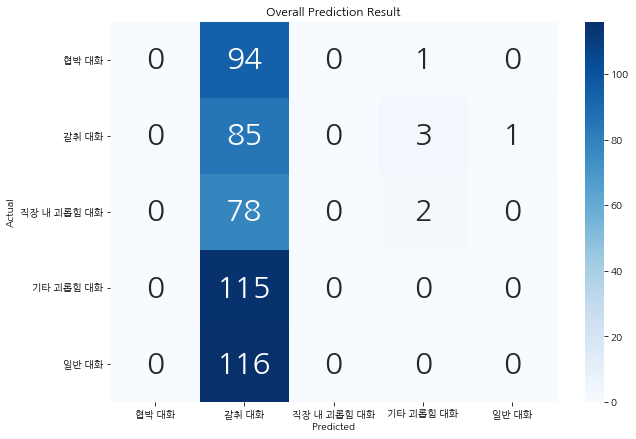

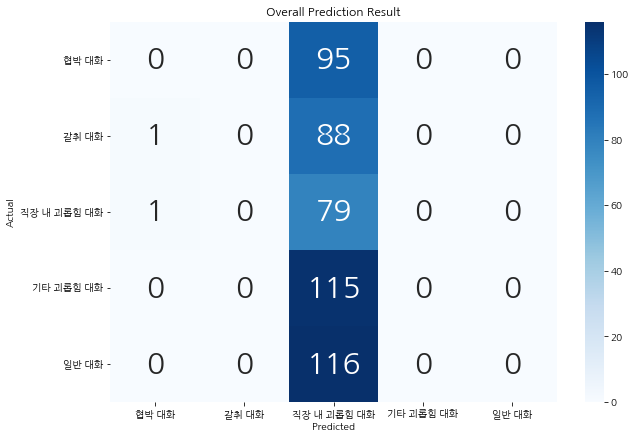

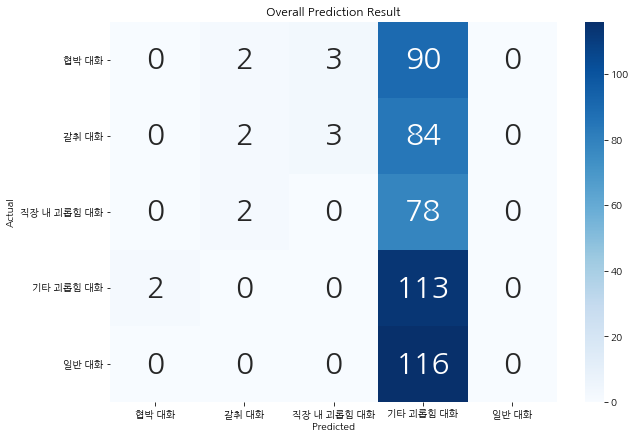

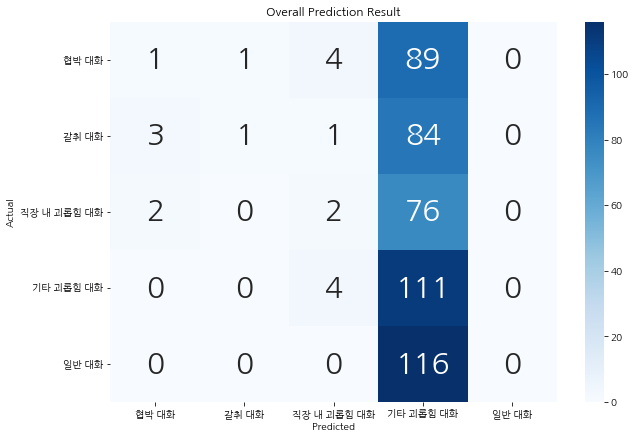

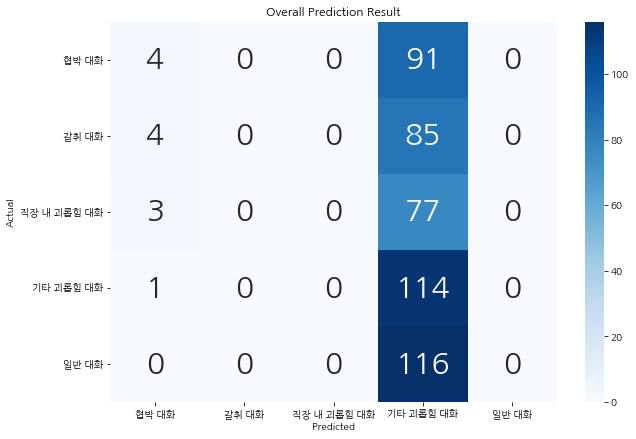

In [49]:
# train()에 인자가 있으므로 wrapper function 정의
def sweep_train():
    train(default_config=default_config, X_test=X_test, y_test=y_test)

# 팀프로젝트 내에서 sweep 실행
sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_minions',
                       project = 'DLthon_baseline_GRU')


wandb.agent(sweep_id,
            function=sweep_train,
            count=5)